# KANLLPR: KAN with Last-Layer Prediction Rigidity

This notebook demonstrates the KANLLPR implementation, which combines:
- **KAN (Kolmogorov-Arnold Networks)**: Learnable B-spline activations on edges
- **LLPR (Last-Layer Prediction Rigidity)**: Principled uncertainty quantification

## What is LLPR?

LLPR provides uncertainty estimates by computing how "rigid" a prediction is with respect to perturbations in the last-layer features:

$$\sigma^2(x_*) = \alpha^2 \cdot f_*^T \cdot (F^T F + \zeta^2 I)^{-1} \cdot f_*$$

where:
- $f_*$ = last-layer features for input $x_*$
- $F$ = matrix of last-layer features from training data
- $\alpha^2$ = uncertainty scaling parameter
- $\zeta^2$ = regularization parameter

**Advantages over ensemble methods:**
- Single forward pass (no ensemble overhead)
- Principled covariance-based uncertainty
- Auto-calibration on validation set

**References:**
- Bigi, F., et al. (2024). A prediction rigidity formalism for low-cost uncertainties in trained neural networks. ML: Sci. Technol., 5, 045018.
- Liu, Z., et al. (2024). KAN: Kolmogorov-Arnold Networks. arXiv:2404.19756.

See this article for a related uncertainty quantification approach using the delta method

- Ni Zhan and John R. Kitchin, Uncertainty quantification in machine learning and nonlinear least squares regression models, AICHE J, 68(6), e17516 (2021). https://aiche.onlinelibrary.wiley.com/doi/10.1002/aic.17516 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Set JAX to use CPU (optional, for reproducibility)
import os

os.environ["JAX_PLATFORM_NAME"] = "cpu"

from pycse.sklearn import KANLLPR

## 1. Basic Usage: Single Output Regression

Let's start with fitting a simple sinusoidal function with noise.

In [2]:
# Generate sinusoidal data with noise
np.random.seed(42)
X = np.linspace(0, 2 * np.pi, 150)[:, None]
y_true = np.sin(X.ravel())
y = y_true + 0.1 * np.random.randn(150)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train KANLLPR
# val_size=0.2 reserves 20% of training data for LLPR calibration
model = KANLLPR(
    layers=(1, 8, 1),  # 1 input, 8 hidden, 1 output
    grid_size=5,
    val_size=0.2,  # For auto-calibration of α² and ζ²
    seed=42,
)
model.fit(X_train, y_train, maxiter=300)

# Report training results
model.report()

W0000 00:00:1767122239.921387 3724208 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1767122239.940529 3724208 service.cc:145] XLA service 0x600001991100 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767122239.940682 3724208 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1767122239.942089 3724208 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1767122239.942095 3724208 mps_client.cc:384] XLA backend will use up to 51539132416 bytes on device 0 for SimpleAllocator.


Metal device set to: Apple M4 Pro
Calibrated: α²=7.85e-01, ζ²=3.79e-01, NLL=-0.4713
KANLLPR Model Report:
  Architecture: (1, 8, 1)
  Grid size: 5
  Spline order: 3
  Optimizer: bfgs
  Iterations: 300
  Final loss: 0.015583
  Converged: False
  LLPR α²: 7.85e-01
  LLPR ζ²: 3.79e-01
  Feature dimension: 8


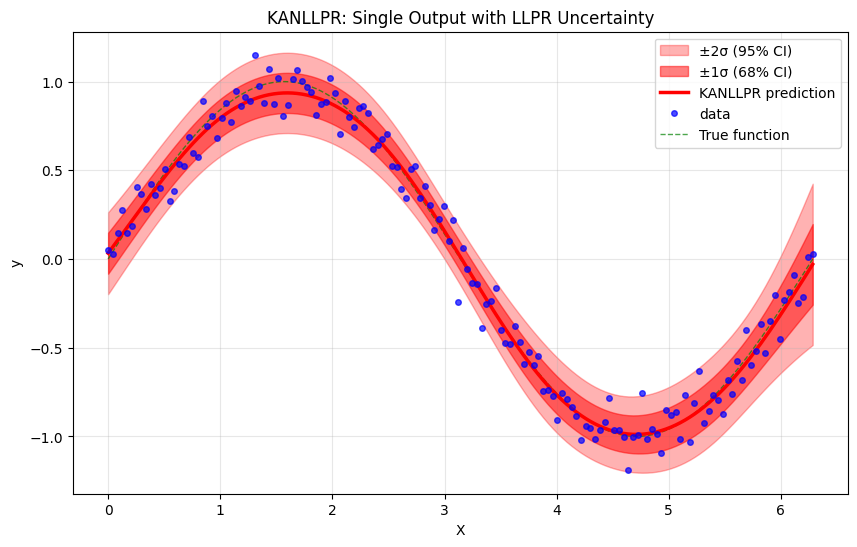

R² score on test set: 0.9812


In [3]:
# Predict with uncertainty
y_pred, y_std = model.predict_with_uncertainty(X)

# Use built-in plot method
plt.figure(figsize=(10, 6))
model.plot(X, y)
plt.plot(X, y_true, "g--", linewidth=1, alpha=0.7, label="True function")
plt.legend()
plt.title("KANLLPR: Single Output with LLPR Uncertainty")
plt.show()

print(f"R² score on test set: {model.score(X_test, y_test):.4f}")

## 2. Understanding LLPR Calibration

LLPR auto-calibrates two parameters on the validation set:
- **α² (alpha_squared)**: Scales the overall uncertainty magnitude
- **ζ² (zeta_squared)**: Regularizes the covariance matrix inversion

The calibration minimizes the negative log-likelihood (NLL) on the validation set.

In [4]:
# Print uncertainty metrics
model.print_metrics(X_test, y_test)


KANLLPR UNCERTAINTY QUANTIFICATION METRICS

Prediction Accuracy:
  RMSE: 0.094643
  MAE:  0.073652

Uncertainty Quality:
  NLL: -0.912638
  Miscalibration Area: 0.049413

Calibration Diagnostics:
  Z-score mean: 0.1904 (ideal: 0)
  Z-score std:  0.8696 (ideal: 1)

Coverage:
  Within 1σ: 0.767 (expected: 0.683)
  Within 2σ: 0.967 (expected: 0.955)
  Within 3σ: 1.000 (expected: 0.997)



### Interpreting the Metrics

- **RMSE/MAE**: Prediction accuracy (lower is better)
- **NLL**: Negative log-likelihood - measures both accuracy AND calibration (lower is better)
- **Z-score mean**: Should be ~0 for well-calibrated uncertainties
- **Z-score std**: Should be ~1 for well-calibrated uncertainties
- **Coverage**: Fraction of true values within predicted confidence intervals
  - Within 1σ: expected 68.3%
  - Within 2σ: expected 95.5%
  - Within 3σ: expected 99.7%

## 3. Heteroscedastic Data

Let's test KANLLPR on data where noise varies with input (heteroscedastic).

In [5]:
# Generate heteroscedastic data (noise increases with X)
np.random.seed(42)
X = np.linspace(0, 1, 200)[:, None]
noise_level = 0.02 + 0.15 * X.ravel()  # Increasing noise
y_true = X.ravel() ** (1 / 3)  # Cube root function
y = y_true + noise_level * np.random.randn(200)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train KANLLPR
model_het = KANLLPR(layers=(1, 8, 1), grid_size=5, val_size=0.2, seed=42)
model_het.fit(X_train, y_train, maxiter=300)
model_het.report()

Calibrated: α²=2.07e+00, ζ²=1.13e-03, NLL=0.2880
KANLLPR Model Report:
  Architecture: (1, 8, 1)
  Grid size: 5
  Spline order: 3
  Optimizer: bfgs
  Iterations: 300
  Final loss: 0.180189
  Converged: False
  LLPR α²: 2.07e+00
  LLPR ζ²: 1.13e-03
  Feature dimension: 8


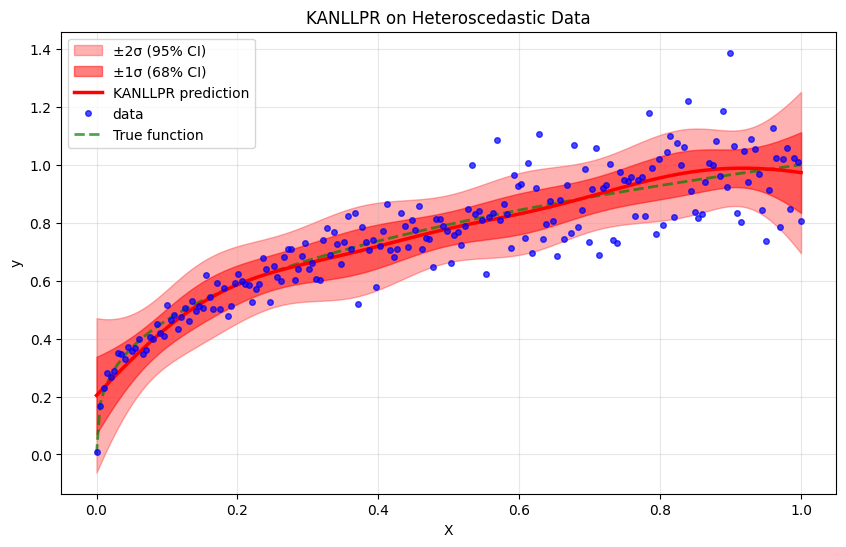


KANLLPR UNCERTAINTY QUANTIFICATION METRICS

Prediction Accuracy:
  RMSE: 0.096987
  MAE:  0.072235

Uncertainty Quality:
  NLL: -0.753122
  Miscalibration Area: 0.059978

Calibration Diagnostics:
  Z-score mean: 0.1927 (ideal: 0)
  Z-score std:  1.4038 (ideal: 1)

Coverage:
  Within 1σ: 0.600 (expected: 0.683)
  Within 2σ: 0.825 (expected: 0.955)
  Within 3σ: 0.950 (expected: 0.997)



In [6]:
# Visualize predictions with uncertainty
plt.figure(figsize=(10, 6))
model_het.plot(X, y)
plt.plot(X, y_true, "g--", linewidth=2, alpha=0.7, label="True function")
plt.legend()
plt.title("KANLLPR on Heteroscedastic Data")
plt.show()

# Print metrics
model_het.print_metrics(X_test, y_test)

### Note on Heteroscedastic Data

LLPR assumes homoscedastic (constant) noise in its formulation. For heteroscedastic data:
- The uncertainty bands may not perfectly capture the varying noise level
- Consider using ensemble-based KAN (`n_ensemble > 1`) for heteroscedastic UQ
- LLPR still provides useful relative uncertainty (higher where predictions are less certain)

## 4. Multi-Output Regression with Per-Output Calibration

KANLLPR supports multiple outputs, with **separate calibration** for each output. This is important when outputs have different noise characteristics.

In [7]:
# Generate multi-output data with different noise levels per output
np.random.seed(42)
n_samples = 200
X = np.random.rand(n_samples, 2)  # 2D input

# Two outputs with DIFFERENT noise levels
y1 = np.sin(2 * np.pi * X[:, 0]) + 0.05 * np.random.randn(n_samples)  # Low noise
y2 = np.cos(2 * np.pi * X[:, 1]) + 0.25 * np.random.randn(n_samples)  # High noise
y = np.column_stack([y1, y2])

print("Output 1 noise std: 0.05")
print("Output 2 noise std: 0.25")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

Output 1 noise std: 0.05
Output 2 noise std: 0.25
X shape: (200, 2)
y shape: (200, 2)


In [8]:
# Train multi-output KANLLPR
# layers[-1] = 2 for two outputs
model_multi = KANLLPR(
    layers=(2, 8, 2),  # 2 inputs, 8 hidden, 2 outputs
    grid_size=5,
    val_size=0.2,
    seed=42,
)
model_multi.fit(X, y, maxiter=300)

# Report shows per-output calibration
model_multi.report()

Output 0: α²=1.83e-01, ζ²=7.85e-03, NLL=-0.9488
Output 1: α²=3.36e+00, ζ²=3.79e-01, NLL=0.2809
KANLLPR Model Report:
  Architecture: (2, 8, 2)
  Grid size: 5
  Spline order: 3
  Optimizer: bfgs
  Iterations: 300
  Final loss: 0.051571
  Converged: False
  LLPR calibration (per output):
    Output 0: α²=1.83e-01, ζ²=7.85e-03
    Output 1: α²=3.36e+00, ζ²=3.79e-01
  Feature dimension: 8


### Per-Output Calibration

Notice how each output has different α² and ζ² values:
- Output 0 (low noise): Lower α² → smaller uncertainty bands
- Output 1 (high noise): Higher α² → larger uncertainty bands

This allows the model to provide appropriate uncertainty estimates for each output independently.

In [9]:
# Predict with per-output uncertainties
y_pred, y_std = model_multi.predict_with_uncertainty(X)

print(f"Predictions shape: {y_pred.shape}")
print(f"Uncertainties shape: {y_std.shape}")
print()
print(f"Mean uncertainty for Output 0 (low noise):  {y_std[:, 0].mean():.4f}")
print(f"Mean uncertainty for Output 1 (high noise): {y_std[:, 1].mean():.4f}")

Predictions shape: (200, 2)
Uncertainties shape: (200, 2)

Mean uncertainty for Output 0 (low noise):  0.0654
Mean uncertainty for Output 1 (high noise): 0.2652


In [10]:
# Print detailed metrics including per-output breakdown
model_multi.print_metrics(X, y)


KANLLPR UNCERTAINTY QUANTIFICATION METRICS
(Aggregated over 2 outputs)

Prediction Accuracy:
  RMSE: 0.143507
  MAE:  0.113838

Uncertainty Quality:
  NLL: -0.749727
  Miscalibration Area: 0.025394

Calibration Diagnostics:
  Z-score mean: -0.0267 (ideal: 0)
  Z-score std:  0.8631 (ideal: 1)

Coverage:
  Within 1σ: 0.762 (expected: 0.683)
  Within 2σ: 0.978 (expected: 0.955)
  Within 3σ: 1.000 (expected: 0.997)

Per-Output Metrics:
  Output 0: RMSE=0.0500, NLL=-1.5041, z_mean=-0.054, z_std=0.796
  Output 1: RMSE=0.2370, NLL=0.0046, z_mean=0.001, z_std=0.924



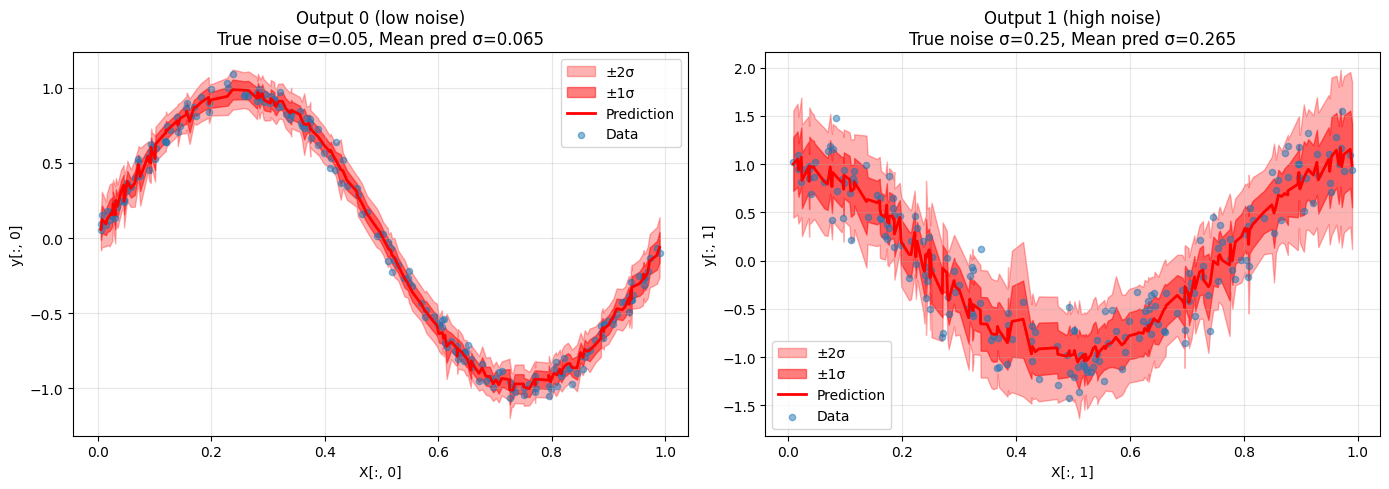

In [11]:
# Visualize multi-output predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for j, (ax, title, noise) in enumerate(
    zip(axes, ["Output 0 (low noise)", "Output 1 (high noise)"], [0.05, 0.25])
):
    # Sort by first input for visualization
    sort_idx = np.argsort(X[:, j])
    x_sorted = X[sort_idx, j]
    y_sorted = y[sort_idx, j]
    pred_sorted = y_pred[sort_idx, j]
    std_sorted = y_std[sort_idx, j]

    ax.fill_between(
        x_sorted,
        pred_sorted - 2 * std_sorted,
        pred_sorted + 2 * std_sorted,
        alpha=0.3,
        color="red",
        label="±2σ",
    )
    ax.fill_between(
        x_sorted,
        pred_sorted - std_sorted,
        pred_sorted + std_sorted,
        alpha=0.5,
        color="red",
        label="±1σ",
    )
    ax.plot(x_sorted, pred_sorted, "r-", linewidth=2, label="Prediction")
    ax.scatter(x_sorted, y_sorted, alpha=0.5, s=20, label="Data")
    ax.set_xlabel(f"X[:, {j}]")
    ax.set_ylabel(f"y[:, {j}]")
    ax.set_title(f"{title}\nTrue noise σ={noise}, Mean pred σ={std_sorted.mean():.3f}")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Comparison: KANLLPR vs KAN (Ensemble)

Let's compare the two UQ approaches:
- **KANLLPR**: LLPR-based covariance uncertainty (single output head)
- **KAN**: Ensemble-based uncertainty (multiple output heads)

In [12]:
from pycse.sklearn import KAN

# Generate test data
np.random.seed(42)
X = np.linspace(0, 2 * np.pi, 150)[:, None]
y_true = np.sin(X.ravel())
y = y_true + 0.1 * np.random.randn(150)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
import time

# Train KANLLPR
t0 = time.time()
kanllpr = KANLLPR(layers=(1, 8, 1), grid_size=5, val_size=0.2, seed=42)
kanllpr.fit(X_train, y_train, maxiter=300)
t_llpr = time.time() - t0

# Train KAN with ensemble
t0 = time.time()
kan_ens = KAN(layers=(1, 8, 1), grid_size=5, n_ensemble=32, loss_type="crps", seed=42)
kan_ens.fit(X_train, y_train, val_X=X_test, val_y=y_test, maxiter=300)
t_ens = time.time() - t0

print(f"KANLLPR training time: {t_llpr:.2f}s")
print(f"KAN ensemble training time: {t_ens:.2f}s")

Calibrated: α²=7.85e-01, ζ²=3.79e-01, NLL=-0.4713

Calibration factor α = 0.9766
  ✓ Model is well-calibrated
KANLLPR training time: 22.02s
KAN ensemble training time: 46.16s


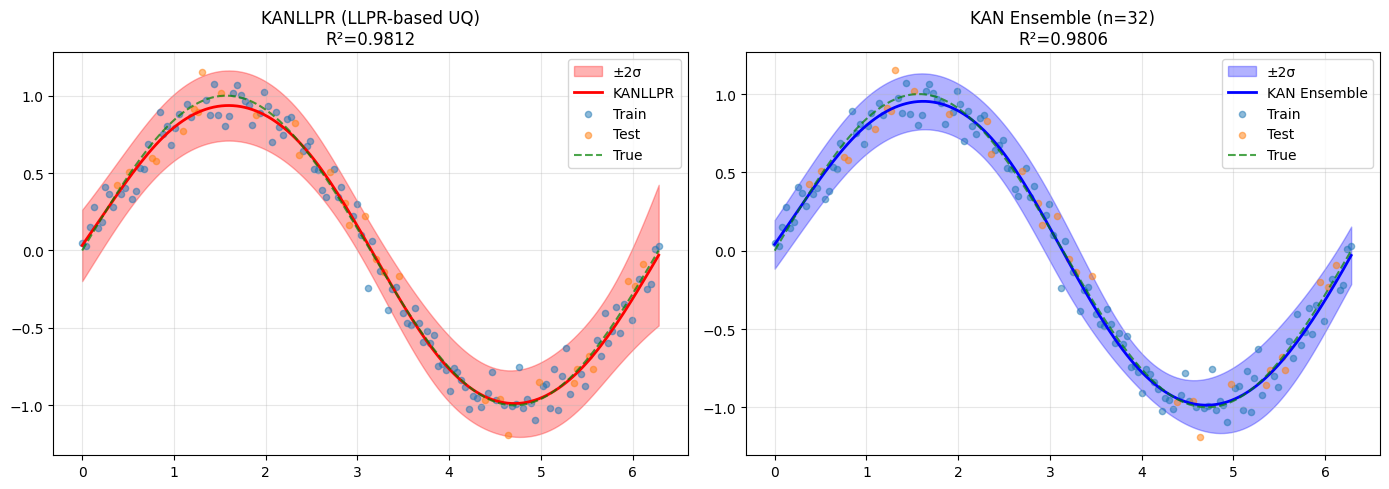

In [14]:
# Compare predictions
y_pred_llpr, y_std_llpr = kanllpr.predict_with_uncertainty(X)
y_pred_ens, y_std_ens = kan_ens.predict(X, return_std=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# KANLLPR
ax = axes[0]
ax.fill_between(
    X.ravel(),
    y_pred_llpr - 2 * y_std_llpr,
    y_pred_llpr + 2 * y_std_llpr,
    alpha=0.3,
    color="red",
    label="±2σ",
)
ax.plot(X, y_pred_llpr, "r-", linewidth=2, label="KANLLPR")
ax.scatter(X_train, y_train, alpha=0.5, s=20, label="Train")
ax.scatter(X_test, y_test, alpha=0.5, s=20, label="Test")
ax.plot(X, y_true, "g--", alpha=0.7, label="True")
ax.set_title(f"KANLLPR (LLPR-based UQ)\nR²={kanllpr.score(X_test, y_test):.4f}")
ax.legend()
ax.grid(True, alpha=0.3)

# KAN Ensemble
ax = axes[1]
ax.fill_between(
    X.ravel(),
    y_pred_ens - 2 * y_std_ens,
    y_pred_ens + 2 * y_std_ens,
    alpha=0.3,
    color="blue",
    label="±2σ",
)
ax.plot(X, y_pred_ens, "b-", linewidth=2, label="KAN Ensemble")
ax.scatter(X_train, y_train, alpha=0.5, s=20, label="Train")
ax.scatter(X_test, y_test, alpha=0.5, s=20, label="Test")
ax.plot(X, y_true, "g--", alpha=0.7, label="True")
ax.set_title(f"KAN Ensemble (n=32)\nR²={kan_ens.score(X_test, y_test):.4f}")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:
# Compare metrics
print("KANLLPR Metrics:")
print("-" * 40)
metrics_llpr = kanllpr.uncertainty_metrics(X_test, y_test)
for k, v in metrics_llpr.items():
    if k != "per_output":
        print(f"  {k}: {v:.4f}")

print()
print("KAN Ensemble Metrics:")
print("-" * 40)
metrics_ens = kan_ens.uncertainty_metrics(X_test, y_test)
for k, v in metrics_ens.items():
    print(f"  {k}: {v:.4f}")

KANLLPR Metrics:
----------------------------------------
  rmse: 0.0946
  mae: 0.0737
  nll: -0.9126
  miscalibration_area: 0.0494
  z_score_mean: 0.1904
  z_score_std: 0.8696
  fraction_within_1_sigma: 0.7667
  fraction_within_2_sigma: 0.9667
  fraction_within_3_sigma: 1.0000

KAN Ensemble Metrics:
----------------------------------------
  rmse: 0.0962
  mae: 0.0763
  nll: -0.8919
  miscalibration_area: 0.0467
  z_score_mean: 0.2094
  z_score_std: 1.0257


### Comparison Summary

| Aspect | KANLLPR | KAN Ensemble |
|--------|---------|-------------|
| **UQ Method** | Covariance from last-layer features | Variance across ensemble heads |
| **Parameters** | α², ζ² (per output) | n_ensemble, calibration_factor |
| **Forward Passes** | 1 | 1 (multiple output heads) |
| **Memory** | O(n_features²) covariance | O(n_ensemble) outputs |
| **Multi-output** | Per-output calibration | Shared calibration |
| **Heteroscedastic** | Limited (assumes homoscedastic) | Better (learns variance) |

## 6. Manual Calibration Parameters

You can also specify fixed α² and ζ² values instead of auto-calibration.

In [16]:
# Train with manual calibration parameters
model_manual = KANLLPR(
    layers=(1, 8, 1),
    grid_size=5,
    alpha_squared=0.5,  # Fixed α²
    zeta_squared=1e-6,  # Fixed ζ²
    val_size=0.0,  # No validation split needed
    seed=42,
)
model_manual.fit(X_train, y_train, maxiter=300)
model_manual.report()

KANLLPR Model Report:
  Architecture: (1, 8, 1)
  Grid size: 5
  Spline order: 3
  Optimizer: bfgs
  Iterations: 300
  Final loss: 0.016860
  Converged: False
  LLPR α²: 5.00e-01
  LLPR ζ²: 1.00e-06
  Feature dimension: 8


## 7. Regularization Options

KANLLPR supports the same regularization options as KAN:
- **l1_spline**: L1 penalty on spline coefficients (encourages sparse activations)
- **l1_activation**: L1 penalty on activation outputs
- **entropy_reg**: Entropy regularization (sharper activation functions)

In [17]:
# Train with L1 regularization
model_reg = KANLLPR(layers=(1, 8, 1), grid_size=5, l1_spline=0.01, val_size=0.2, seed=42)
model_reg.fit(X_train, y_train, maxiter=300)
model_reg.report()

print(f"\nR² score: {model_reg.score(X_test, y_test):.4f}")

Calibrated: α²=7.85e-01, ζ²=3.79e-01, NLL=-0.4711
KANLLPR Model Report:
  Architecture: (1, 8, 1)
  Grid size: 5
  Spline order: 3
  Optimizer: bfgs
  Regularization:
    L1 spline: 0.01
  Iterations: 300
  Final loss: 0.018322
  Converged: False
  LLPR α²: 7.85e-01
  LLPR ζ²: 3.79e-01
  Feature dimension: 8

R² score: 0.9813


## Summary

**KANLLPR** combines KAN's learnable spline activations with LLPR's principled uncertainty quantification:

### Key Features:
1. **LLPR-based UQ**: Covariance from last-layer features
2. **Auto-calibration**: Grid search over α², ζ² on validation set
3. **Multi-output support**: Per-output calibration parameters
4. **Single forward pass**: Efficient inference
5. **sklearn compatible**: fit/predict/score interface

### When to use KANLLPR:
- When you need principled uncertainty estimates
- For multi-output problems with different noise levels
- When single-pass inference is important
- For smooth, continuous functions

### When to use KAN with ensemble instead:
- For heteroscedastic data (varying noise)
- When you need full posterior samples
- For uncertainty propagation through nonlinear transformations

### Parameters to tune:
- `layers`: Network architecture (last element = number of outputs)
- `grid_size`: B-spline resolution (default: 5)
- `val_size`: Fraction for calibration (default: 0.1)
- `alpha_squared`, `zeta_squared`: Set to 'auto' or fixed values